# 引入库
python最大的好处就是python下有很多已经写好的库和方法可以调用，这样大大加快了开发的速度。在调用库的具体方法之前需要先import引入一下

> 如果您不熟悉Python，*软件包*实际上是一个包含代码文件的文件夹。这些代码文件被称为*模块*。

要导入相关的模块，请选中下面的元格后按``ctrl + enter``或上面的``play``图标，执行包含在单元中的代码

In [1]:
#author: lengkujiaai@126.com

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-tig60ha2 because the default path (/home/jetbot/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


我们现在已经导入了相关的模块，现在可以使用模块下的方法了。我们在这里定义了类train，在类中定义了一些方法，也用到了别人已经写好的方法。其实类的名字可以随意修改，只是在用自己定义的类创建对象的时候记得添加了哪些功能就行。所以在创建类的时候，起名要遵循见名知意的形式，不要起别人不知道是什么意思自己也不知道是什么意思的名字

In [3]:
image_paths = "dataset/"
model_name = "mask_detector.model"
plot_name = "plot.png"

In [4]:
# 初始化神经网络的学习速率, 批量处理的大小
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("[INFO] 开始加载图片...")
imagePaths = list(paths.list_images(image_paths))
data = []
labels = []

[INFO] 开始加载图片...


In [5]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

In [6]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [8]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
9412608/9406464 [==============================] - 99s 11us/step


In [10]:
for layer in baseModel.layers:
    layer.trainable = False
print("[INFO] 编译模型...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY), validation_steps=len(testX) // BS,epochs=EPOCHS)  

[INFO] 编译模型...
Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
34/34 [==============================] - 217s 6s/step - loss: 0.6210 - acc: 0.6798 - val_loss: 0.3462 - val_acc: 0.9022
Epoch 2/2
34/34 [==============================] - 178s 5s/step - loss: 0.3965 - acc: 0.8165 - val_loss: 0.1995 - val_acc: 0.9493


In [11]:
print("[INFO] 计算神经网络的权值...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] 计算神经网络的权值...
              precision    recall  f1-score   support

   with_mask       0.97      0.93      0.95       138
without_mask       0.93      0.97      0.95       138

    accuracy                           0.95       276
   macro avg       0.95      0.95      0.95       276
weighted avg       0.95      0.95      0.95       276



In [12]:
print("[INFO] 保存检测口罩的模型...")
model.save(model_name, save_format="h5")

[INFO] 保存检测口罩的模型...


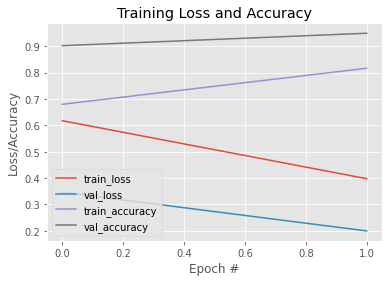

In [15]:
def plot_picture():
    #print(H.history)
    N = EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_accuracy")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    #plt.savefig(plot_name)

#调用自己定义的方法
plot_picture()

### 结论
本示例就是这样！希望你知道了如何利用已经定义的方法训练神经网络模型:)